# ELISA cohorts intervalidation

In this notebook we verify how, training (ratios) models and then running predictions over other models behave.

### Imports and environment setup

- Date of run: 2025-02-20
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')


## Saving repeats IDs for further (re) training

In [4]:
MMP9_repeats = ['002-0012', '012-0029', '003-0005', '003-0009', '006-0020', 
        '003-0056', '015-0048', '03-0009', '06-0020', '03-0056']

HSPB1_repeats = ['002-0004', '002-0018', '002-0019', '004-0003', '018-0016', 
         '001-0004', '002-0023', '020-0001', '001-0040', '007-0013', 
         '010-0007', '005-0007', '007-0002', '012-0018', '016-0043', 
         '003-0039', '003-0043', '011-0002', '012-0016', '012-0014', 
         '003-0022', '009-0026', '006-0045', '015-0023', '020-0077', 
         '005-0009', '004-0007', '015-0048']

KPYM_repeats = ['001-0014', '001-0040', '002-0002', '002-0005', '002-0006', 
        '002-0007', '002-0008', '002-0012', '002-0013', '002-0015', 
        '002-0016', '002-0018', '002-0019', '002-0020', '002-0022', 
        '002-0026', '002-0027', '002-0028', '003-0002', '003-0007', 
        '003-0011', '003-0028', '003-0039', '003-0043', '003-0044', 
        '003-0049', '003-0062', '005-0003', '005-0004', '005-0007', 
        '006-0009', '007-0002', '007-0004', '007-0006', '007-0009', 
        '007-0011', '007-0012', '007-0013', '008-0034', '010-0007', 
        '011-0002', '011-0032', '012-0001', '012-0014', '012-0016', 
        '012-0025', '012-0027', '013-0003', '016-0043', '020-0006', 
        '020-0007', '020-0023', '003-0030']

AGRIN_repeats = ['003-0030', '002-0018', '002-0019', '003-0002', '005-0003', 
         '007-0011', '002-0004', '007-0004', '003-0049', '005-0004', 
         '012-0005', '001-0004', '020-0001', '007-0013', '018-0002', 
         '010-0007', '006-0001', '005-0007', '012-0018', '003-0062', 
         '003-0043', '002-0005', '011-0002', '012-0016', '003-0006', 
         '003-0021', '003-0005', '006-0045', '006-0020', '003-0056', 
         '006-0037']

PERM_repeats = ['001-0013', '012-0005', '001-0009', '001-0004', '003-0039', 
        '007-0012', '002-0016', '002-0022', '004-0008', '003-0030', 
        '010-0012', '018-0016', '003-0022', '003-0005', '003-0009', 
        '003-0067', '015-0049', '003-0090', '013-0047', '006-0020', 
        '005-0009', '003-0056', '005-0012', '004-0007', '006-0031', 
        '006-0037', '015-0048', '003-0006']

PIGR_repeats = ["001-0004","001-0005","001-0008","001-0011","001-0012",
                "001-0019","001-0040","001-0063","002-0002","002-0012",
                "002-0013","002-0023","002-0025","003-0002","003-0006",
                "003-0009","003-0012","003-0022","003-0030","003-0056",
                "003-0070","003-0088","003-0090","004-0001","004-0003",
                "004-0007","004-0008","004-0009","005-0003","005-0008",
                "005-0012","006-0001","006-0009","007-0002","007-0006",
                "009-0026","010-0007","012-0001","012-0003","012-0005",
                "012-0007","012-0008","012-0013","012-0015","012-0016",
                "012-0025","012-0027","013-0003","013-0006","013-0047",
                "014-0024","014-0026","015-0048","015-0049","016-0033",
                "018-0001","018-0002","018-0016","020-0001","020-0006",
                "020-0014","020-0034","020-0047","020-0049","020-0050",
                "016-0043","020-0015"]



## Loading of 0.5mL cohort

In [5]:
df_500 = pd.read_csv('../data/60x60_dr_mmk_20250224.csv' , sep='\t', index_col=0, header=0)
# Harmonization of column names
df_500 = utils.normalize_column_names(df_500)

In [6]:
df_500_old = pd.read_csv('../data/60x60_dr_mmk_20241208.csv' , sep='\t', index_col=0, header=0)
#Harmonization of column names
df_500_old = utils.normalize_column_names(df_500_old)

#convert zeros to NaN
df_500 = df_500.replace(0, np.nan)
df_500_old = df_500_old.replace(0, np.nan)

In [7]:
#df_500 = df_500_old

In [8]:
# The TIMP2_repeats are those with df_500_old["TIMP-2"] == np.nan and df_500["TIMP-2"] != np.nan
TIMP2_repeats = df_500_old[df_500_old["TIMP-2"].isnull() & df_500["TIMP-2"].notnull()].index.to_list()
ADIPOQ_repeats = df_500_old[df_500_old["ADIPOQ"].isnull() & df_500["ADIPOQ"].notnull()].index.to_list()


In [9]:
# Ensure numeric columns are treated as such
cols_500_to_num = ['Collected_volume_mL', 'pH',
                    'MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM', 'PIGR', 'Total_protein_BCA']
df_500 = utils.cols_as_numbers(df_500, cols_500_to_num)

In [10]:
# Columns to be considered as biomarkers
BIOMARKERS_500 = ['MMP9', 'TIMP-2', 'AGRIN', 'KPYM', 'PIGR']


### Create new columns for biomarker ratios

In [11]:
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_500:
    for biomarker2 in BIOMARKERS_500:
        if biomarker1 != biomarker2:
            df_500[f'{biomarker1}_{biomarker2}'] = df_500[biomarker1].div(df_500[biomarker2], axis=0)
            # Make infinite values NaN
            df_500[f'{biomarker1}_{biomarker2}'] = df_500[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [12]:
# Ensure categorical columns are treated as such
df_500 = utils.cols_as_category(df_500, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

### Execution parameters

In [13]:
PLOT_ROCS = False
MAX_BIOMARKER_COUNT = 3
RESULTS_PATH = '../data/results/elisa_intercohort/500mL/'

# The biomarkers now include the ratios
BIOMARKERS_500 = [f"{biomarker1}_{biomarker2}" for biomarker1 in BIOMARKERS_500 for biomarker2 in BIOMARKERS_500 if biomarker1 != biomarker2]

NORMALIZING_COL_500 = 'Total_protein_BCA' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

METHODS = ['direct']

### Computing the model

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [14]:
models_120 = utils.compute_all_models_and_save(
                            df=df_500,
                            biomarkers=BIOMARKERS_500,
                            normalizing_col=NORMALIZING_COL_500, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=2,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            auc_threshold=0.0,
                            )

### Removing repeats

In [15]:
# Remove repeats from the df_500 in a copy
#df_500_no_repeats = df_500.copy()
#df_500_no_repeats = df_500_no_repeats[~df_500_no_repeats.index.isin(TIMP2_repeats)]
#df_500_no_repeats = df_500_no_repeats[~df_500_no_repeats.index.isin(PIGR_repeats)]
#df_500_no_repeats = df_500_no_repeats[~df_500_no_repeats.index.isin(AGRIN_repeats)]
#df_500_no_repeats = df_500_no_repeats[~df_500_no_repeats.index.isin(KPYM_repeats)]
#df_500_no_repeats = df_500_no_repeats[~df_500_no_repeats.index.isin(MMP9_repeats)]


In [16]:
df_500_no_repeats = df_500.copy()
# In df_500_no_repeats we will, for TIMP-2, PIGR, AGRIN, KPYM and MMP9,
# keep the values that are only one standard deviation away from the mean

factor_down = 1
factor_up = 1

# TIMP-2
TIMP2_mean = df_500["TIMP-2"].mean()
TIMP2_std_down = df_500["TIMP-2"].std() * factor_down
TIMP2_std_up = df_500["TIMP-2"].std() * factor_up
df_500_no_repeats = df_500_no_repeats[(df_500_no_repeats["TIMP-2"] > TIMP2_mean - TIMP2_std_down) & (df_500_no_repeats["TIMP-2"] < TIMP2_mean + TIMP2_std_up)]

# PIGR
PIGR_mean = df_500["PIGR"].mean()
PIGR_std_down = df_500["PIGR"].std() * factor_down
PIGR_std_up = df_500["PIGR"].std() * factor_up
df_500_no_repeats = df_500_no_repeats[(df_500_no_repeats["PIGR"] > PIGR_mean - PIGR_std_down) & (df_500_no_repeats["PIGR"] < PIGR_mean + PIGR_std_up)]

# AGRIN
AGRIN_mean = df_500["AGRIN"].mean()
AGRIN_std_down = df_500["AGRIN"].std() * factor_down
AGRIN_std_up = df_500["AGRIN"].std() * factor_up
df_500_no_repeats = df_500_no_repeats[(df_500_no_repeats["AGRIN"] > AGRIN_mean - AGRIN_std_down) & (df_500_no_repeats["AGRIN"] < AGRIN_mean + AGRIN_std_up)]

# # KPYM
# KPYM_mean = df_500["KPYM"].mean()
# KPYM_std_down = df_500["KPYM"].std() * factor_down
# KPYM_std_up = df_500["KPYM"].std() * factor_up
# df_500_no_repeats = df_500_no_repeats[(df_500_no_repeats["KPYM"] > KPYM_mean - KPYM_std_down) & (df_500_no_repeats["KPYM"] < KPYM_mean + KPYM_std_up)]

# MMP9
MMP9_mean = df_500["MMP9"].mean()
MMP9_std_down = df_500["MMP9"].std() * factor_down
MMP9_std_up = df_500["MMP9"].std() * factor_up
df_500_no_repeats = df_500_no_repeats[(df_500_no_repeats["MMP9"] > MMP9_mean - MMP9_std_down) & (df_500_no_repeats["MMP9"] < MMP9_mean + MMP9_std_up)]


In [17]:
df_500_no_repeats.shape

(53, 43)

In [18]:
df_500_no_repeats.Pathology.value_counts()

Pathology
0    35
1    18
Name: count, dtype: int64

In [19]:
RESULTS_PATH = '../data/results/elisa_intercohort/500mL_no-rep/'

models_500_no_repeats = utils.compute_all_models_and_save(
                            df=df_500_no_repeats,
                            biomarkers=BIOMARKERS_500,
                            normalizing_col=NORMALIZING_COL_500, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=2,
                            folder_name=RESULTS_PATH,
                            plot_rocs=False,
                            auc_threshold=0.0,
                            )

In [20]:
selected_model=('TIMP-2_MMP9','AGRIN_PIGR')

In [21]:
# How many rows of the df_500 has no-nan values for TIMP-2, MMP9, AGRIN and PIGR
df_500[["TIMP-2", "MMP9", "AGRIN", "PIGR"]].dropna().shape[0]

89

In [22]:
df_500[["TIMP-2", "MMP9", "AGRIN", "PIGR"]].shape[0]

120

In [23]:
models_500_no_repeats['direct'][list(models_500_no_repeats['direct'].keys())[0]][selected_model]['auc']


np.float64(0.8746)

In [24]:
bestmodel = models_500_no_repeats['direct'][list(models_500_no_repeats['direct'].keys())[0]][selected_model]['model']
#bestmodel = models_120['direct'][list(models_120['direct'].keys())[0]][selected_model]['model']

In [25]:
predictions = bestmodel.predict(df_500[list(selected_model)].apply(lambda x: np.log(x+1)))

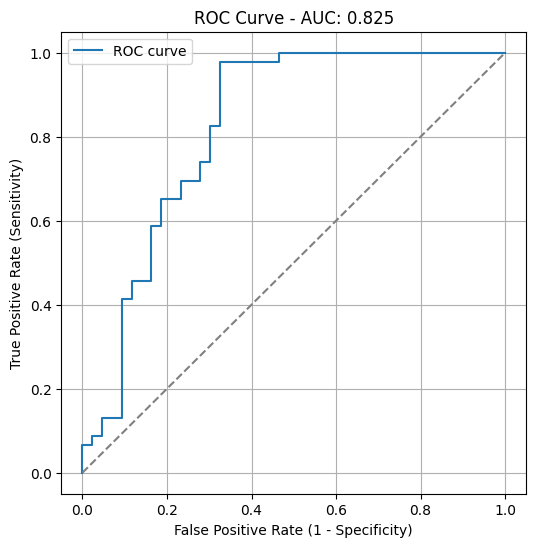

Sensitivity	Specificity
0.978	0.674
0.978	0.535
1.000	0.535
1.000	0.000


In [26]:

# Ensure predictions and true labels align properly
valid_indices = predictions.dropna().index
y_true = df_500.loc[valid_indices, 'Pathology']
y_scores = predictions.loc[valid_indices]

# Compute FPR, TPR, and thresholds
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
roc_auc = roc_auc_score(y_true, y_scores)
plt.title('ROC Curve - AUC: {:.3f}'.format(roc_auc))
plt.legend()
plt.grid()
plt.show()

# Display sensitivity and specificity for threshold with sensitivity >= 0.95
print("Sensitivity\tSpecificity")
for i, t in enumerate(roc_thresholds):
    if tpr[i] >= 0.94:
        print(f"{tpr[i]:.3f}\t{1 - fpr[i]:.3f}")


## Loading of 2mL cohort

In [27]:
# df_2mL = pd.read_csv('../data/2mL_20250220.csv' , sep='\t', index_col=0, header=0)


In [28]:
# # Harmonization of column names
# df_2mL = utils.normalize_column_names(df_2mL)

In [29]:
# # Ensure numeric columns are treated as such
# cols_2mL_to_num = ['TIMP-2', 'ADIPOQ', 'MMP9', 
#                     'KPYM', 'AGRIN', 'PERM', 'HSPB1',
#                     'Total_Protein']
# df_2mL = utils.cols_as_numbers(df_2mL, cols_2mL_to_num)

In [30]:
# # Ensure categorical columns are treated as such
# df_2mL = utils.cols_as_category(df_2mL, {'Pathology':{
#                                             'Benigna': 0, 
#                                             'Adenocarcinoma de endometrio': 1,
#                                             'Otros': np.nan,
#                                             'Hiperplasia atípica endometrial': np.nan,
#                                         }})

In [31]:
# df_2mL.head()

In [32]:
# BIOMARKERS_2mL = ['MMP9', 'TIMP-2', 'AGRIN', 'KPYM']

# # Create new columns with the ratios between the biomarkers
# for biomarker1 in BIOMARKERS_2mL:
#     for biomarker2 in BIOMARKERS_2mL:
#         if biomarker1 != biomarker2:
#             df_2mL[f'{biomarker1}_{biomarker2}'] = df_2mL[biomarker1].div(df_2mL[biomarker2], axis=0)
#             # Make infinite values NaN
#             df_2mL[f'{biomarker1}_{biomarker2}'] = df_2mL[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [33]:
# predictions = bestmodel.predict(df_2mL[list(selected_model)])

In [34]:
# from sklearn.metrics import roc_curve

# # Ensure predictions and true labels align properly
# valid_indices = predictions.dropna().index
# valid_indices_2mL = df_2mL[df_2mL['Pathology'].notnull()].index 
# common_indices = valid_indices.intersection(valid_indices_2mL)

# # compute y_true and y_scores
# y_true = df_2mL.loc[common_indices, 'Pathology']
# y_scores = predictions.loc[common_indices]

# # Compute FPR, TPR, and thresholds
# fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# # Plot the ROC curve
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, label="ROC curve")
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
# roc_auc = roc_auc_score(y_true, y_scores)
# plt.title('ROC Curve - AUC: {:.3f}'.format(roc_auc))
# plt.legend()
# plt.grid()
# plt.show()

# # Display sensitivity and specificity for threshold with sensitivity >= 0.95
# print("Sensitivity\tSpecificity")
# for i, t in enumerate(roc_thresholds):
#     if tpr[i] >= 0.94:
#         print(f"{tpr[i]:.3f}\t{1 - fpr[i]:.3f}")


## Loading of 240 cohort

In [35]:
df_240 = pd.read_csv('../data/mmk_240_20240926.csv', sep=',', index_col=0, header=0)


In [36]:
# Harmonization of column names
df_240 = utils.normalize_column_names(df_240)

# To harmonize with other analyses, change _MIMARK to _MMK in column names
df_240.columns = [col.replace('_MIMARK', '') for col in df_240.columns]

In [37]:
df_240_dr = pd.read_csv('../data/mmk_240_TIMP_ADIPOQ_20250217.csv', sep='\t', index_col=0, header=0)
# Join the two dataframes by the index (named Sample)
df_240 = df_240.join(df_240_dr, how='inner')

In [38]:
# Add the 2022 PoF PIGR data
df_240_11bmk = pd.read_csv('../data/ruo_240_11bmk_20250225.csv', sep='\t', index_col=0, header=0)
df_240 = df_240.join(df_240_11bmk[["PIGR"]], how='inner')

In [39]:
# Filter only the menopausic patients
# df_240_11bmk_old = pd.read_csv('../data/ruo_240_11bmk_20250201.csv', sep='\t', index_col=0, header=0)
# filter_index = df_240_11bmk_old.query('tipo_histologico == "Seroso" or Pathology == "Benigna"').index.to_list()
# # Ensure the indices are present in df_240
# filter_index = [idx for idx in filter_index if idx in df_240.index]
# df_240 = df_240.loc[filter_index]

In [40]:
# Ensure numeric columns are treated as such
cols_to_num = ["TP_2022","AGRIN","KPYM","HSPB1","PERM","MMP9","TP_2024","TIMP-2","ADIPOQ", "PIGR"]
df_240 = utils.cols_as_numbers(df_240, cols_to_num)

In [41]:
# Columns to be considered as biomarkers
BIOMARKERS_240 = ['MMP9', 'PERM', 'TIMP-2', 'AGRIN', 'KPYM', 'PIGR']


In [42]:
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_240:
    for biomarker2 in BIOMARKERS_240:
        if biomarker1 != biomarker2:
            df_240[f'{biomarker1}_{biomarker2}'] = df_240[biomarker1].div(df_240[biomarker2], axis=0)
            # Make infinite values NaN
            df_240[f'{biomarker1}_{biomarker2}'] = df_240[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [43]:
# Ensure categorical columns are treated as such
df_240 = utils.cols_as_category(df_240, {'Condition':{'Benign': 0, 'Endometrial cancer': 1}})
# Rename 'Condition' column to 'Pathology'
df_240.rename(columns={'Condition': 'Pathology'}, inplace=True)

In [44]:
predictions = bestmodel.predict(df_240[list(selected_model)])

In [45]:
predictions.shape

(105,)

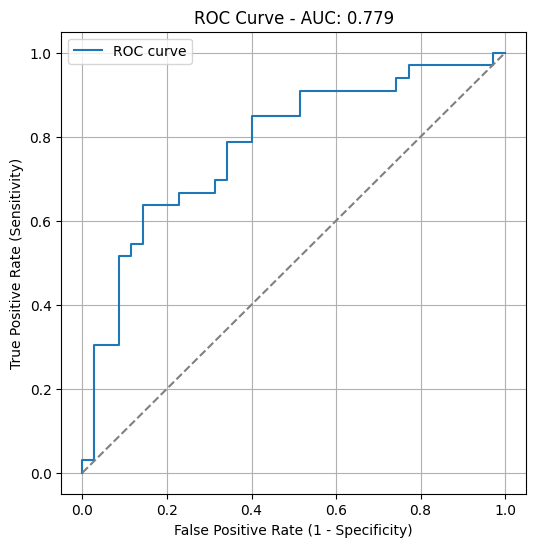

Sensitivity	Specificity
0.848	0.600
0.848	0.486
0.909	0.486
0.909	0.257
0.939	0.257
0.939	0.229
0.970	0.229
0.970	0.029
1.000	0.029
1.000	0.000


In [46]:
from sklearn.metrics import roc_curve

# Ensure predictions and true labels align properly
valid_indices = predictions.dropna().index
valid_indices_2mL = df_240[df_240['Pathology'].notnull()].index 
common_indices = valid_indices.intersection(valid_indices_2mL)

# compute y_true and y_scores
y_true = df_240.loc[common_indices, 'Pathology']
y_scores = predictions.loc[common_indices]

# Compute FPR, TPR, and thresholds
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
# Compute the AUC 
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_true, y_scores)
plt.title('ROC Curve - AUC: {:.3f}'.format(roc_auc))
plt.legend()
plt.grid()
plt.show()

# Display sensitivity and specificity for threshold with sensitivity >= 0.95
print("Sensitivity\tSpecificity")
for i, t in enumerate(roc_thresholds):
    if tpr[i] >= 0.8:
        print(f"{tpr[i]:.3f}\t{1 - fpr[i]:.3f}")


## Comparing the repeated and not repeated samples for TIMP-2

In [47]:
df_500['KPYM_repeats'] = df_500.index.isin(KPYM_repeats)
df_500['AGRIN_repeats'] = df_500.index.isin(AGRIN_repeats)
df_500['PERM_repeats'] = df_500.index.isin(PERM_repeats)
df_500['PIGR_repeats'] = df_500.index.isin(PIGR_repeats)
df_500['HSPB1_repeats'] = df_500.index.isin(HSPB1_repeats)
df_500['MMP9_repeats'] = df_500.index.isin(MMP9_repeats)
df_500['TIMP2_repeats'] = df_500.index.isin(TIMP2_repeats)

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_by_biomarker_repeats(df, biomarker, repeats_col, apply_log=False):
    """
    Plot the distribution of a biomarker, split by its corresponding repeats column, 
    as a unique violin plot divided into two halves.

    Parameters:
    df (pd.DataFrame): The dataset containing the biomarker data.
    biomarker (str): The name of the biomarker column (e.g., 'TIMP-2', 'KPYM').
    repeats_col (str): The name of the corresponding repeats column (e.g., 'TIMP2_repeats', 'KPYM_repeats').
    apply_log (bool): Whether to apply log(x+1) transformation to the biomarker values (default: False).
    """

    # Ensure the repeats column is treated as a categorical variable
    df['Biomarker_group'] = df[repeats_col].astype(str)

    # Apply log(x+1) transformation if specified
    if apply_log:
        df[f'log_{biomarker}'] = np.log1p(df[biomarker])
        plot_column = f'log_{biomarker}'  # Use transformed data
    else:
        plot_column = biomarker  # Use raw data

    # Compute mean and standard deviation for both groups
    stats = df.groupby('Biomarker_group')[plot_column].agg(['mean', 'std']).reset_index()

    # Set up the figure with correct size
    plt.figure(figsize=(8, 8))

    # Define fixed x-positions: **True (Left), False (Right)**
    x_positions_fixed = {'True': -0.15, 'False': 0.15}

    # Create a split violin plot with **forced hue order (True on Left, False on Right)**
    sns.violinplot(
        x=['Merged'] * len(df),
        y=df[plot_column], 
        hue=df['Biomarker_group'], 
        data=df, 
        split=True, 
        scale='count', 
        inner=None,
        hue_order=['True', 'False']  # **Forces correct left-right order**
    )

    # Add swarm plot for individual points with correct hue order
    sns.swarmplot(
        x=['Merged'] * len(df), 
        y=df[plot_column], 
        hue=df['Biomarker_group'], 
        data=df, 
        dodge=True,
        alpha=0.6, 
        marker='o', 
        edgecolor='black', 
        linewidth=0.5,
        hue_order=['True', 'False']  # **Ensures correct order**
    )

    # **Get available groups and apply correct x-positions**
    unique_groups = df['Biomarker_group'].unique()
    x_positions = {group: x_positions_fixed[group] for group in unique_groups if group in x_positions_fixed}

    # Track min and max y-values for correct ylim
    y_min, y_max = df[plot_column].min(), df[plot_column].max()

    # Add mean and standard deviation lines + labels
    for _, row in stats.iterrows():
        mean = row['mean']
        std = row['std']
        group = row['Biomarker_group']

        # **Ensure x_pos is correctly mapped**
        if group not in x_positions:
            continue  # Skip if group is missing

        x_pos = x_positions[group]  # Now correctly mapped to left or right

        # Plot mean line
        plt.hlines(y=mean, xmin=x_pos - 0.08, xmax=x_pos + 0.08, colors='black', linestyles='solid', lw=2)

        # Plot ±SD lines
        plt.hlines(y=[mean - std, mean + std], xmin=x_pos - 0.05, xmax=x_pos + 0.05, colors='black', linestyles='dashed', lw=1)

        # Annotate mean & SD values
        plt.text(x_pos, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
        plt.text(x_pos, mean + std, f'+SD {round(mean+std,2)}', ha='center', va='bottom', fontsize=9, color='black')

        # Ensure -SD annotation is visible
        if mean - std > y_min:
            plt.text(x_pos, mean - std * 1.02, f'-SD {round(mean-std,2)}', ha='center', va='top', fontsize=9, color='black')
        else:
            plt.text(x_pos, y_min * 1.1, f'-SD (out of range {round(mean-std,2)})', ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

    # Set title dynamically based on biomarker and transformation
    title_suffix = "(log-transformed)" if apply_log else ""
    plt.title(f'Distribution of {biomarker} values by {repeats_col} {title_suffix}')

    # Remove unwanted line legends but keep the hue legend
    plt.legend(title=repeats_col)

    plt.show()


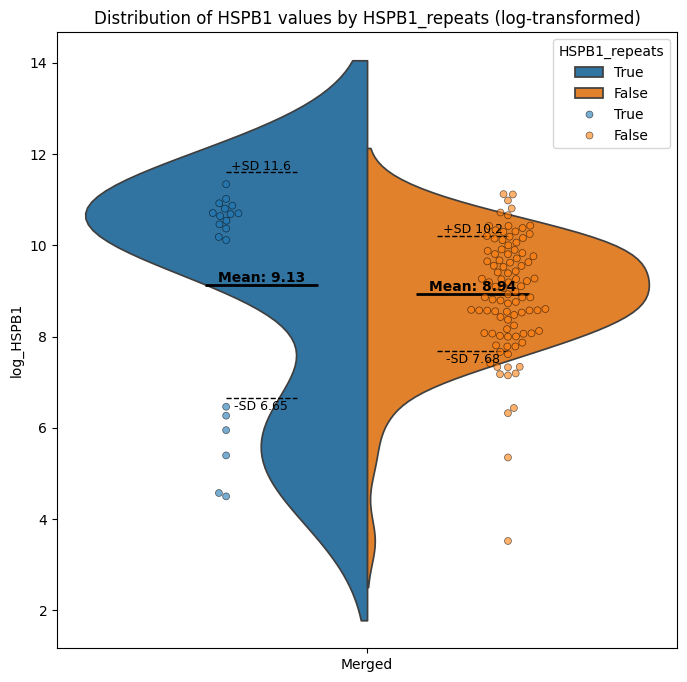

In [55]:
plot_by_biomarker_repeats(df_500, 'HSPB1', 'HSPB1_repeats', True)

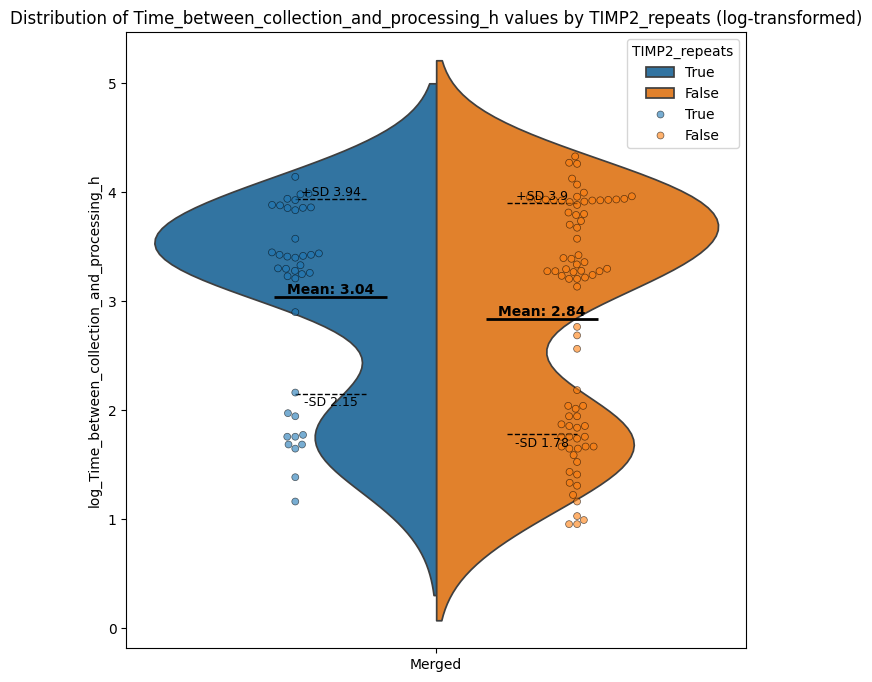

In [50]:
plot_by_biomarker_repeats(df_500, 'Time_between_collection_and_processing_h', 'TIMP2_repeats', True)

In [51]:
df_500.columns

Index(['Collection_center', 'Age', 'Pathology', 'Hystology_grade',
       'Hystology_type', 'FIGO_stage_2009', 'TCGA',
       'Time_between_collection_and_processing_h', 'Group_time',
       'Collected_volume_mL', 'Sample_visual_description', 'Hemolysis', 'pH',
       'Collected_at', 'MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN',
       'KPYM', 'Total_protein_BCA', 'PIGR', 'MMP9_TIMP-2', 'MMP9_AGRIN',
       'MMP9_KPYM', 'MMP9_PIGR', 'TIMP-2_MMP9', 'TIMP-2_AGRIN', 'TIMP-2_KPYM',
       'TIMP-2_PIGR', 'AGRIN_MMP9', 'AGRIN_TIMP-2', 'AGRIN_KPYM', 'AGRIN_PIGR',
       'KPYM_MMP9', 'KPYM_TIMP-2', 'KPYM_AGRIN', 'KPYM_PIGR', 'PIGR_MMP9',
       'PIGR_TIMP-2', 'PIGR_AGRIN', 'PIGR_KPYM', 'KPYM_repeats',
       'AGRIN_repeats', 'PERM_repeats', 'PIGR_repeats', 'HSPB1_repeats',
       'MMP9_repeats', 'TIMP2_repeats', 'Biomarker_group', 'log_PERM',
       'log_Time_between_collection_and_processing_h'],
      dtype='object')

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_timp2_by_pathology(df, apply_log=False):
    """
    Plot the distribution of TIMP-2 split by Pathology (Benign vs. Cancer) and TIMP2_repeats,
    with an option to apply a log(x+1) transformation.

    Parameters:
    df (pd.DataFrame): The dataset containing TIMP-2 values.
    apply_log (bool): Whether to apply log(x+1) transformation to the TIMP-2 values (default: False).
    """

    # Ensure TIMP2_repeats is treated as a categorical variable
    df['TIMP2_group'] = df['TIMP2_repeats'].astype(str)

    # Apply log(x+1) transformation if specified
    if apply_log:
        df['log_TIMP-2'] = np.log1p(df['TIMP-2'])
        plot_column = 'log_TIMP-2'  # Use transformed data
    else:
        plot_column = 'TIMP-2'  # Use raw data

    # Compute mean and standard deviation for each Pathology group
    stats = df.groupby(['Pathology', 'TIMP2_group'])[plot_column].agg(['mean', 'std']).reset_index()

    # Set up the figure with two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # Define pathology labels for plotting
    pathology_labels = {0: "Benign", 1: "Cancer"}

    # **Reverse x-positions: True (Left), False (Right)**
    x_positions_fixed = {'True': -0.15, 'False': 0.15}  # True now on left

    # Loop through each Pathology group and create the split violin plots
    for idx, pathology in enumerate([0, 1]):
        ax = axes[idx]

        # Filter data for this Pathology type
        df_subset = df[df['Pathology'] == pathology]

        # Create a split violin plot with **forced hue order (True on Left, False on Right)**
        sns.violinplot(
            x=['Merged'] * len(df_subset),
            y=df_subset[plot_column], 
            hue=df_subset['TIMP2_group'], 
            data=df_subset, 
            split=True, 
            scale='count', 
            inner=None,
            hue_order=['True', 'False'],  # **Forces True (left) and False (right)**
            ax=ax
        )

        # Add swarm plot for individual points with correct hue order
        sns.swarmplot(
            x=['Merged'] * len(df_subset), 
            y=df_subset[plot_column], 
            hue=df_subset['TIMP2_group'], 
            data=df_subset, 
            dodge=True,
            alpha=0.6, 
            marker='o', 
            edgecolor='black', 
            linewidth=0.5,
            hue_order=['True', 'False'],  # **Ensures correct side**
            ax=ax
        )

        # **Get available groups and use fixed x-positions**
        unique_groups = df_subset['TIMP2_group'].unique()
        x_positions = {group: x_positions_fixed[group] for group in unique_groups if group in x_positions_fixed}

        # Track min and max y-values for correct ylim
        y_min, y_max = df_subset[plot_column].min(), df_subset[plot_column].max()

        # Add mean and standard deviation lines + labels
        for _, row in stats[stats['Pathology'] == pathology].iterrows():
            mean = row['mean']
            std = row['std']
            group = row['TIMP2_group']

            # **Ensure x_pos is correctly mapped**
            if group not in x_positions:
                continue  # Skip if group is missing

            x_pos = x_positions[group]  # Now correctly mapped to left or right

            # Plot mean line
            ax.hlines(y=mean, xmin=x_pos - 0.08, xmax=x_pos + 0.08, colors='black', linestyles='solid', lw=2)

            # Plot ±SD lines
            ax.hlines(y=[mean - std, mean + std], xmin=x_pos - 0.05, xmax=x_pos + 0.05, colors='black', linestyles='dashed', lw=1)

            # Annotate mean & SD values
            ax.text(x_pos, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
            ax.text(x_pos, mean + std, f'+SD {round(mean+std,2)}', ha='center', va='bottom', fontsize=9, color='black')

            # Ensure -SD annotation is visible
            if mean - std > y_min:
                ax.text(x_pos, mean - std * 1.02, f'-SD {round(mean-std,2)}', ha='center', va='top', fontsize=9, color='black')
            else:
                ax.text(x_pos, y_min * 1.1, f'-SD (out of range {round(mean-std,2)})', ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

        # Set title for each subplot
        title_suffix = "(log-transformed)" if apply_log else ""
        ax.set_title(f'Distribution of TIMP-2 for {pathology_labels[pathology]} {title_suffix}', fontsize=12)

        # Remove unwanted legend duplicates
        if idx == 1:
            ax.legend(title='TIMP2_repeats')
        else:
            ax.get_legend().remove()

    # Adjust layout
    plt.tight_layout()
    plt.show()


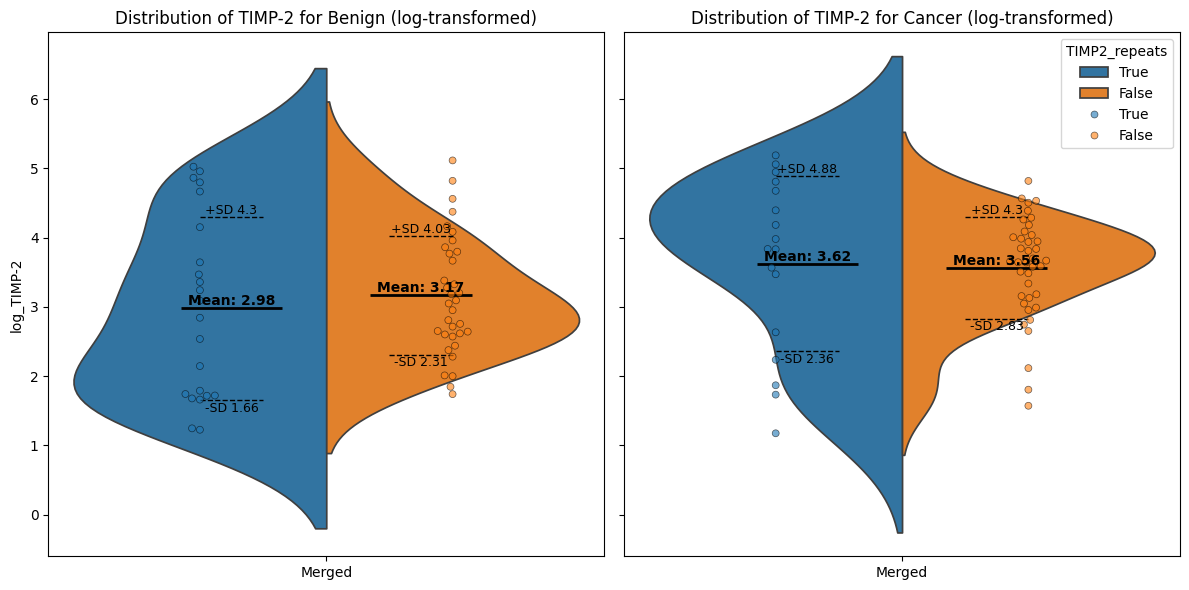

In [53]:
plot_timp2_by_pathology(df_500, apply_log=True)
